# Cross validation

> In this example, we'll implement time series cross-validation to evaluate model's performance. 

::: {.callout-warning collapse="true"}

## Prerequesites

This tutorial assumes basic familiarity with `MLForecast`. For a minimal example visit the [Quick Start](https://nixtla.github.io/mlforecast/docs/quick_start_local.html) 
:::

## Introduction 

Time series cross-validation is a method for evaluating how a model would have performed in the past. It works by defining a sliding window across the historical data and predicting the period following it. 

![](https://raw.githubusercontent.com/Nixtla/statsforecast/main/nbs/imgs/ChainedWindows.gif) 

[MLForecast](https://nixtla.github.io/mlforecast/) has an implementation of time series cross-validation that is fast and easy to use. This implementation makes cross-validation a efficient operation, which makes it less time-consuming. In this notebook, we'll use it on a subset of the [M4 Competition](https://www.sciencedirect.com/science/article/pii/S0169207019301128) hourly dataset. 

**Outline:**

1. Install libraries 
2. Load and explore data 
3. Train model
4. Perform time series cross-validation 
5. Evaluate results 

::: {.callout-tip}
You can use Colab to run this Notebook interactively <a href="https://colab.research.google.com/github/Nixtla/mlforecast/blob/main/nbs/docs/cross_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
::: 

## Install libraries

We assume that you have `MLForecast` already installed. If not, check this guide for instructions on [how to install MLForecast](https://nixtla.github.io/mlforecast/docs/install.html).

Install the necessary packages with `pip install mlforecast`.

In [ ]:
%%capture
pip install mlforecast lightgbm

In [ ]:
from mlforecast import MLForecast # required to instantiate MLForecast object and use cross-validation method 

## Load and explore the data

As stated in the introduction, we'll use the M4 Competition hourly dataset. We'll first import the data from an URL using `pandas`. 

In [ ]:
import pandas as pd 

Y_df = pd.read_csv('https://datasets-nixtla.s3.amazonaws.com/m4-hourly.csv') # load the data 
Y_df.head() 

,unique_id,ds,y
0,H1,1,605.0
1,H1,2,586.0
2,H1,3,586.0
3,H1,4,559.0
4,H1,5,511.0


The input to `MLForecast` is a data frame in [long format](https://www.theanalysisfactor.com/wide-and-long-data/) with three columns: `unique_id`, `ds` and `y`: 

- The `unique_id` (string, int, or category) represents an identifier for the series. 
- The `ds` (datestamp or int) column should be either an integer indexing time or a datestamp in format YYYY-MM-DD or YYYY-MM-DD HH:MM:SS. 
- The `y` (numeric) represents the measurement we wish to forecast. 

The data in this example already has this format, so no changes are needed. 

We can plot the time series we'll work with using the following function.  

In [ ]:
import matplotlib.pyplot as plt

def plot(df, last_n=24 * 14):
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 6), gridspec_kw=dict(hspace=0.5))
    uids = df['unique_id'].unique()
    for i, (uid, axi) in enumerate(zip(uids, ax.flat)):
        legend = i % 2 == 0
        df[df['unique_id'].eq(uid)].tail(last_n).set_index('ds').plot(ax=axi, title=uid, legend=legend)

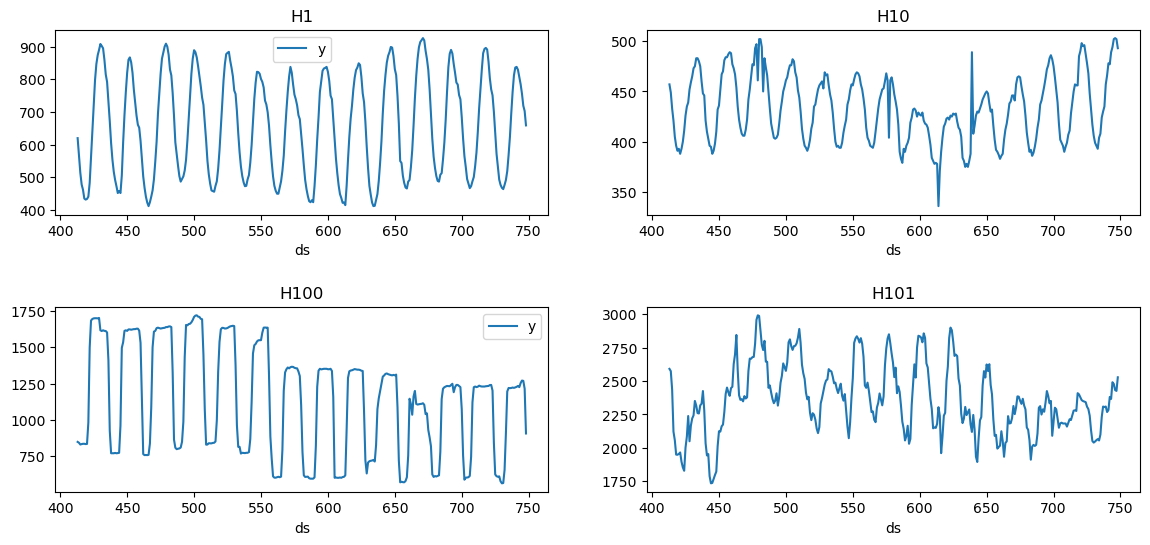

In [ ]:
plot(Y_df)

## Train model

For this example, we'll use LightGBM. We first need to import it and then we need to instantiate a new `MLForecast` object. 

The `MLForecast` object has the following parameters: 

- `models`: a list of sklearn-like (`fit` and `predict`) models. 
- `freq`: a string indicating the frequency of the data. See [panda’s available frequencies.](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases)
- `differences`: Differences to take of the target before computing the features. These are restored at the forecasting step.
- `lags`: Lags of the target to use as features.

In this example, we are only using `differences` and `lags` to produce features. See [the full documentation](https://nixtla.github.io/mlforecast/forecast.html) to see all available features.

Any settings are passed into the constructor. Then you call its `fit` method and pass in the historical data frame `df`. 

In [ ]:
import lightgbm as lgb

models = [lgb.LGBMRegressor()]

mlf = MLForecast(
    models = models, 
    freq = 1,# our series have integer timestamps, so we'll just add 1 in every timeste, 
    differences=[24],
    lags=range(1, 25, 1)
)

## Perform time series cross-validation

Once the `MLForecast` object has been instantiated, we can use the `cross_validation` method, which takes the following arguments: 

- `data`: training data frame with `MLForecast` format 
- `window_size` (int): represents the h steps into the future that will be forecasted 
- `n_windows` (int): number of windows used for cross-validation, meaning the number of forecasting processes in the past you want to evaluate. 
- `id_col`: identifies each time series.
- `time_col`: indetifies the temporal column of the time series. 
- `target_col`: identifies the column to model.

For this particular example, we'll use 3 windows of 24 hours.

In [ ]:
crossvalidation_df = mlf.cross_validation(
    data=Y_df,
    window_size=24,
    n_windows=3,
    id_col='unique_id',
    time_col='ds',
    target_col='y'
)

The crossvaldation_df object is a new data frame that includes the following columns:

- `unique_id`: identifies each time series.
- `ds`: datestamp or temporal index.
- `cutoff`: the last datestamp or temporal index for the `n_windows`. 
- `y`: true value
- `"model"`: columns with the model’s name and fitted value.

In [ ]:
crossvalidation_df.head()

,unique_id,ds,cutoff,y,LGBMRegressor
0,H1,677,676,691.0,673.703191
1,H1,678,676,618.0,552.306270
2,H1,679,676,563.0,541.778027
3,H1,680,676,529.0,502.778027
4,H1,681,676,504.0,480.778027


We'll now plot the forecast for each cutoff period.

In [ ]:
def plot_cv(df, df_cv, uid, last_n=24 * 14):
    cutoffs = df_cv.query('unique_id == @uid')['cutoff'].unique()
    fig, ax = plt.subplots(nrows=len(cutoffs), ncols=1, figsize=(14, 6), gridspec_kw=dict(hspace=0.8))
    for cutoff, axi in zip(cutoffs, ax.flat):
        df.query('unique_id == @uid').tail(last_n).set_index('ds').plot(ax=axi, title=uid, y='y')
        df_cv.query('unique_id == @uid & cutoff == @cutoff').set_index('ds').plot(ax=axi, title=uid, y='LGBMRegressor')

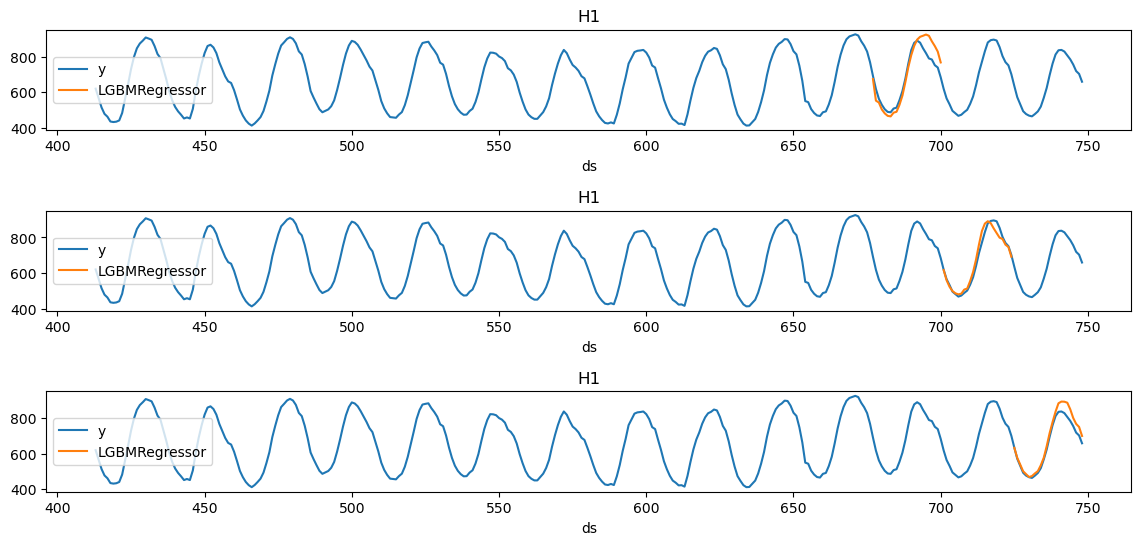

In [ ]:
plot_cv(Y_df, crossvalidation_df, 'H1')

Notice that in each cutoff period, we generated a forecast for the next 24 hours using only the data `y` before said period.  

## Evaluate results 

We can now compute the accuracy of the forecast using an appropiate accuracy metric. Here we'll use the [Root Mean Squared Error (RMSE).](https://en.wikipedia.org/wiki/Root-mean-square_deviation) To do this, we first need to install [datasetsforecast](https://github.com/Nixtla/datasetsforecast/tree/main/), a Python library developed by Nixtla that includes a function to compute the RMSE. 

In [ ]:
%%capture
pip install datasetsforecast

In [ ]:
from datasetsforecast.losses import rmse  

The function to compute the RMSE takes two arguments: 
    
1. The actual values.  
2. The forecasts, in this case, `LGBMRegressor`. 

In this case we will compute the `rmse` per time series and cutoff and then we will take the mean of the results.

In [ ]:
cv_rmse = crossvalidation_df.groupby(['unique_id', 'cutoff']).apply(lambda df: rmse(df['y'], df['LGBMRegressor'])).mean()
print("RMSE using cross-validation: ", cv_rmse)

RMSE using cross-validation:  249.90517171185527


This measure should better reflect the predictive abilities of our model, since it used different time periods to test its accuracy. 

## References 

[Rob J. Hyndman and George Athanasopoulos (2018). "Forecasting principles and practice, Time series cross-validation"](https://otexts.com/fpp3/tscv.html).